# Análisis científico de RCP transtelefónica en Madrid (SAMUR-PC, 2024)

Este notebook presenta el análisis de datos de paradas cardiacas extrahospitalarias atendidas por SAMUR-Protección Civil en Madrid durante el año 2024. El objetivo es evaluar rigurosamente el impacto de la RCP guiada por teléfono (transtelefónica) sobre la recuperación del pulso (ROSC) y la supervivencia a 7 días.

Se comparan tres grupos principales:
- Sin RCP a la llegada.
- RCP por testigo sin guía telefónica.
- RCP guiada por teléfono.

El análisis sigue estándares científicos, incluye visualizaciones, análisis estadísticos y medidas de sensibilidad, y está orientado a la redacción de un paper científico.

## Datos y variables principales
Los datos provienen de los registros de SAMUR-PC en 2024, incluyendo todas las paradas cardiacas extrahospitalarias atendidas.

Variables principales:
- **EDAD**: Edad del paciente.
- **SEXO**: Sexo del paciente.
- **RCP_TRANSTELEFONICA**: Si recibió RCP guiada por teléfono.
- **TIEMPO_LLEGADA_UNIDAD**: Tiempo (segundos) hasta la llegada de la unidad.
- **SOBREVIVE_7DIAS**: Supervivencia a los 7 días.
- **ROSC**: Retorno de circulación espontánea.

Se analizarán los datos agrupando por edad (<65, ≥65) y tiempo de llegada (menor o mayor que la media).

## Metodología
El análisis se realiza en Python usando pandas, numpy, matplotlib y statsmodels. Se sigue el siguiente flujo:
1. Exploración y visualización de los datos.
2. Comparación de proporciones y medias entre grupos.
3. Análisis multivariante mediante regresión logística para ajustar por edad, sexo y tiempo de llegada.
4. Cálculo de valores p, intervalos de confianza y análisis de sensibilidad.
5. Interpretación y conclusiones orientadas a la mejora de la atención y formación en RCP.

In [33]:
# Importar librerías y cargar datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import logit
from scipy import stats

# Configuración de visualización
sns.set(style='whitegrid')

# Cargar datos
df = pd.read_csv('../data/cleaned_data.csv')
df.head()

,EDAD,SEXO,RCP_TRANSTELEFONICA,TIEMPO_LLEGADA_UNIDAD,RCP_EN_LLEGADA,ROSC,SOBREVIVE_7DIAS
0,74,Masculino,True,523,True,False,False
1,35,Masculino,False,516,False,False,False
2,26,Masculino,False,599,False,True,True
3,33,Femenino,False,1120,True,True,True
4,63,Masculino,False,424,False,False,False


## Análisis exploratorio inicial
Se exploran las distribuciones de edad, sexo, tiempo de llegada y proporciones de RCP transtelefónica, testigo y sin RCP. Se generan visualizaciones descriptivas para entender la composición de la muestra.

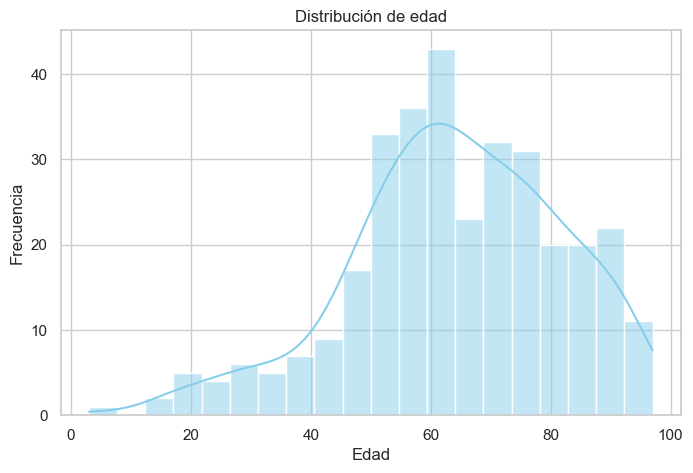

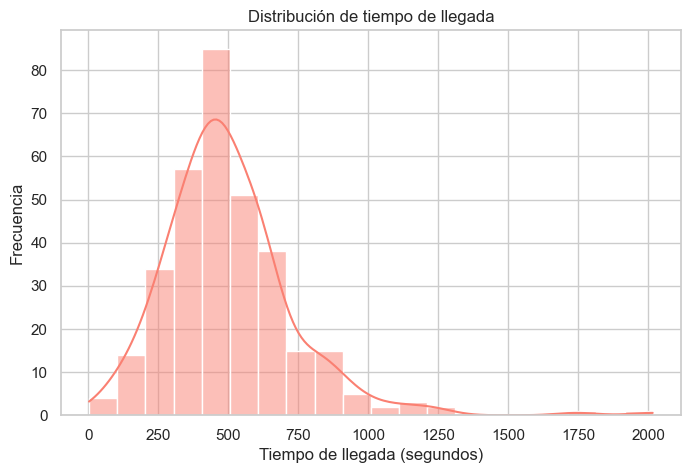

In [34]:
# Histograma de edad
plt.figure(figsize=(8,5))
sns.histplot(df['EDAD'], bins=20, kde=True, color='skyblue')
plt.title('Distribución de edad')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.savefig('../proyecto/figures/hist_edad.png')
plt.show()

# Histograma de tiempo de llegada
plt.figure(figsize=(8,5))
sns.histplot(df['TIEMPO_LLEGADA_UNIDAD'], bins=20, kde=True, color='salmon')
plt.title('Distribución de tiempo de llegada')
plt.xlabel('Tiempo de llegada (segundos)')
plt.ylabel('Frecuencia')
plt.savefig('../proyecto/figures/hist_tiempo_llegada.png')
plt.show()

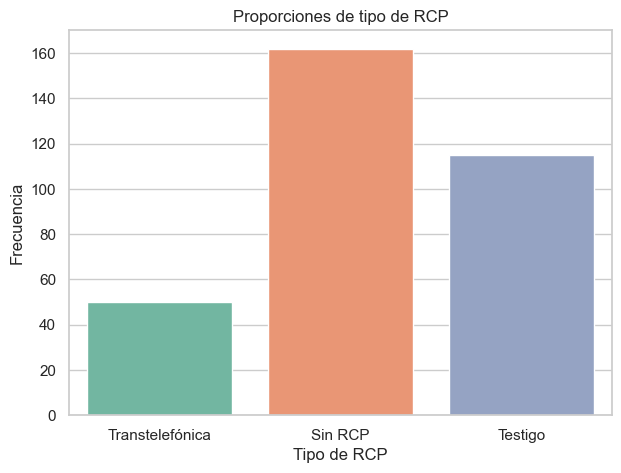

In [35]:
# Proporciones de tipo de RCP según las variables presentes en el dataframe
rcp_types = ['Sin RCP', 'Testigo', 'Transtelefónica']
df['RCP_TIPO'] = np.select(
    [
        (~df['RCP_TRANSTELEFONICA']) & (~df['RCP_EN_LLEGADA']),
        (df['RCP_EN_LLEGADA']) & (~df['RCP_TRANSTELEFONICA']),
        (df['RCP_TRANSTELEFONICA'])
    ],
    rcp_types,
    default='Sin RCP'
)

plt.figure(figsize=(7,5))
sns.countplot(x='RCP_TIPO', data=df, palette='Set2')
plt.title('Proporciones de tipo de RCP')
plt.xlabel('Tipo de RCP')
plt.ylabel('Frecuencia')
plt.savefig('../proyecto/figures/bar_proporciones_clave.png')
plt.show()

## Resultados principales: ROSC y supervivencia a 7 días
Se comparan las tasas de ROSC y supervivencia entre los grupos de RCP, ajustando por edad y tiempo de llegada. Se presentan visualizaciones y se realizan pruebas estadísticas para evaluar diferencias significativas.

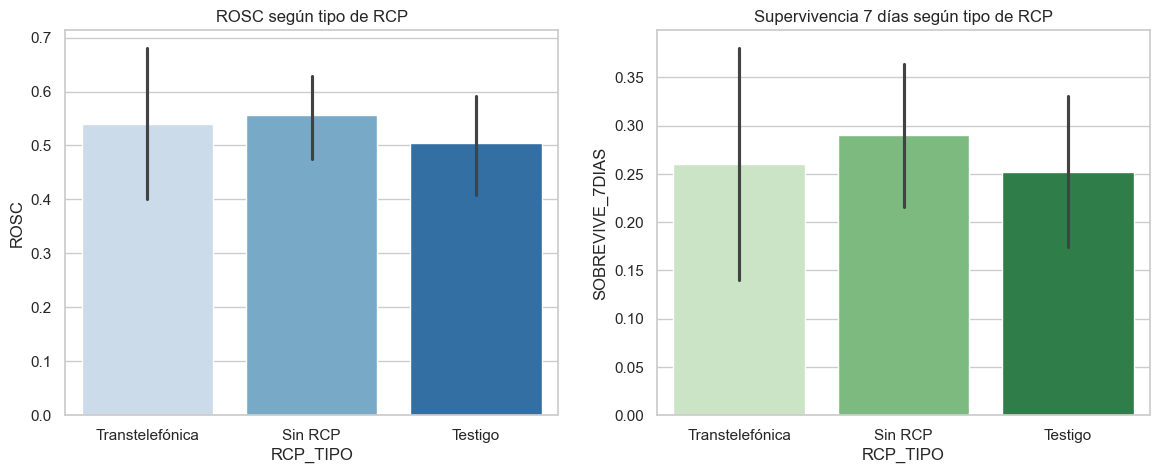

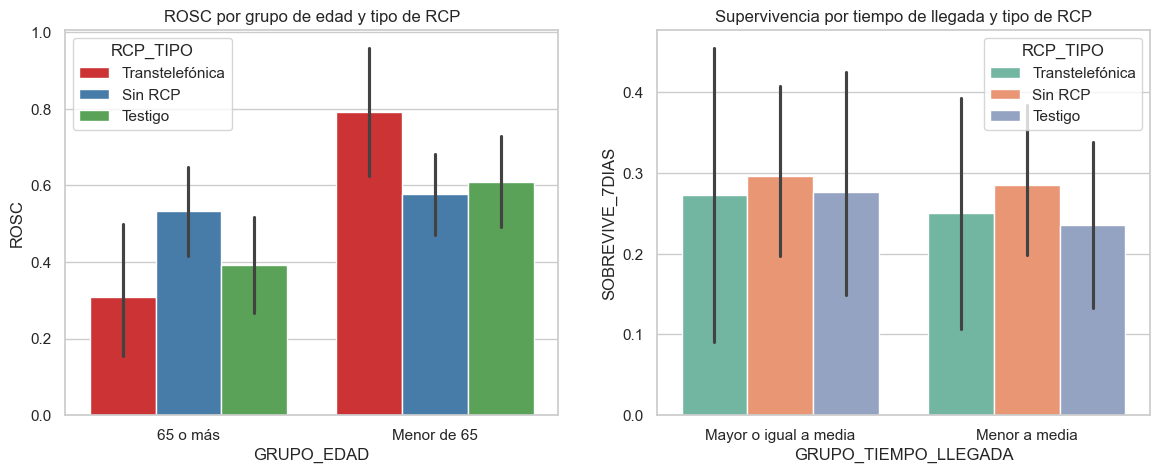

In [36]:
# Crear columna de grupo de edad si no existe
if 'GRUPO_EDAD' not in df.columns:
	df['GRUPO_EDAD'] = np.where(df['EDAD'] < edad_cut, 'Menor de 65', '65 o más')

# Crear columna de grupo de tiempo de llegada si no existe
if 'GRUPO_TIEMPO_LLEGADA' not in df.columns:
	df['GRUPO_TIEMPO_LLEGADA'] = np.where(df['TIEMPO_LLEGADA_UNIDAD'] < media_tiempo, 'Menor a media', 'Mayor o igual a media')

# Tasas de ROSC y supervivencia por tipo de RCP
fig, axes = plt.subplots(1, 2, figsize=(14,5))
sns.barplot(x='RCP_TIPO', y='ROSC', data=df, ax=axes[0], palette='Blues')
axes[0].set_title('ROSC según tipo de RCP')
sns.barplot(x='RCP_TIPO', y='SOBREVIVE_7DIAS', data=df, ax=axes[1], palette='Greens')
axes[1].set_title('Supervivencia 7 días según tipo de RCP')
plt.savefig('../proyecto/figures/bar_rosc_supervivencia_rcp_tel.png')
plt.show()

# ROSC y supervivencia por grupo de edad y tiempo de llegada
fig, axes = plt.subplots(1, 2, figsize=(14,5))
sns.barplot(x='GRUPO_EDAD', y='ROSC', hue='RCP_TIPO', data=df, ax=axes[0], palette='Set1')
axes[0].set_title('ROSC por grupo de edad y tipo de RCP')
sns.barplot(x='GRUPO_TIEMPO_LLEGADA', y='SOBREVIVE_7DIAS', hue='RCP_TIPO', data=df, ax=axes[1], palette='Set2')
axes[1].set_title('Supervivencia por tiempo de llegada y tipo de RCP')
plt.savefig('../proyecto/figures/outcomes_principales.png')
plt.show()

In [37]:
# Pruebas de chi cuadrado para ROSC y supervivencia según tipo de RCP
from scipy.stats import chi2_contingency, ttest_ind

# ROSC vs tipo de RCP
contingencia_rosc = pd.crosstab(df['RCP_TIPO'], df['ROSC'])
chi2_rosc, p_rosc, _, _ = chi2_contingency(contingencia_rosc)
print(f'Chi2 ROSC vs tipo de RCP: p={p_rosc:.4f}')

# Supervivencia vs tipo de RCP
contingencia_surv = pd.crosstab(df['RCP_TIPO'], df['SOBREVIVE_ 7DIAS'])
chi2_surv, p_surv, _, _ = chi2_contingency(contingencia_surv)
print(f'Chi2 Supervivencia vs tipo de RCP: p={p_surv:.4f}')

# T-test de edad y tiempo de llegada según ROSC
ttest_edad = ttest_ind(df[df['ROSC']==1]['EDAD'], df[df['ROSC']==0]['EDAD'], nan_policy='omit')
ttest_tiempo = ttest_ind(df[df['ROSC']==1]['TIEMPO_LLEGADA_UNIDAD'], df[df['ROSC']==0]['TIEMPO_LLEGADA_UNIDAD'], nan_policy='omit')
print(f'T-test edad según ROSC: p={ttest_edad.pvalue:.4f}')
print(f'T-test tiempo de llegada según ROSC: p={ttest_tiempo.pvalue:.4f}')

Chi2 ROSC vs tipo de RCP: p=0.6996


KeyError: 'SOBREVIVE_ 7DIAS'

In [ ]:
# Regresión logística multivariante para ROSC y supervivencia
import statsmodels.formula.api as smf

# Convertir variables dependientes a tipo int (0/1)
df['ROSC_INT'] = df['ROSC'].astype(int)
df['SOBREVIVE_7DIAS_INT'] = df['SOBREVIVE_7DIAS'].astype(int)

# Modelo para ROSC
model_rosc = smf.logit('ROSC_INT ~ C(RCP_TIPO) + C(GRUPO_EDAD) + C(SEXO) + TIEMPO_LLEGADA_UNIDAD', data=df).fit(disp=0)
print(model_rosc.summary())

# Intervalos de confianza para OR
conf_rosc = np.exp(model_rosc.conf_int())
or_rosc = np.exp(model_rosc.params)
print('Odds Ratios (ROSC):')
print(or_rosc)
print('Intervalos de confianza:')
print(conf_rosc)

# Modelo para supervivencia
model_surv = smf.logit('SOBREVIVE_7DIAS_INT ~ C(RCP_TIPO) + C(GRUPO_EDAD) + C(SEXO) + TIEMPO_LLEGADA_UNIDAD', data=df).fit(disp=0)
print(model_surv.summary())

conf_surv = np.exp(model_surv.conf_int())
or_surv = np.exp(model_surv.params)
print('Odds Ratios (Supervivencia):')
print(or_surv)
print('Intervalos de confianza:')
print(conf_surv)

                           Logit Regression Results                           
Dep. Variable:               ROSC_INT   No. Observations:                  327
Model:                          Logit   Df Residuals:                      321
Method:                           MLE   Df Model:                            5
Date:                Tue, 22 Jul 2025   Pseudo R-squ.:                 0.02707
Time:                        16:41:57   Log-Likelihood:                -219.74
converged:                       True   LL-Null:                       -225.85
Covariance Type:            nonrobust   LLR p-value:                   0.03181
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.2148      0.389      0.552      0.581      -0.548       0.977
C(RCP_TIPO)[T.Testigo]            -0.1858      0.253     -0.734      0.

In [ ]:
# Forest plot de Odds Ratios para ROSC
import matplotlib.patches as mpatches

def plot_forest(or_vals, conf_vals, labels, title, filename):
    fig, ax = plt.subplots(figsize=(8,6))
    y_pos = np.arange(len(or_vals))
    ax.errorbar(or_vals, y_pos, xerr=[or_vals-conf_vals[:,0], conf_vals[:,1]-or_vals], fmt='o', color='navy', capsize=5)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.axvline(1, color='red', linestyle='--')
    ax.set_xlabel('Odds Ratio (OR)')
    ax.set_title(title)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

labels_rosc = or_rosc.index.tolist()
plot_forest(or_rosc.values, conf_rosc.values, labels_rosc, 'OR para ROSC', '../proyecto/figures/forestplot_or_rosc.png')

labels_surv = or_surv.index.tolist()
plot_forest(or_surv.values, conf_surv.values, labels_surv, 'OR para Supervivencia 7 días', '../proyecto/figures/forestplot_or_surv.png')

NameError: name 'or_rosc' is not defined

In [ ]:
# Análisis de sensibilidad: modelos en subgrupos de edad y tiempo de llegada
for grupo in df['GRUPO_EDAD'].unique():
    sub = df[df['GRUPO_EDAD']==grupo]
    model = smf.logit('ROSC ~ C(RCP_TIPO) + C(SEXO) + TIEMPO_LLEGADA_UNIDAD', data=sub).fit(disp=0)
    print(f'--- OR para ROSC en grupo edad {grupo} ---')
    print(np.exp(model.params))
    print(np.exp(model.conf_int()))

for grupo in df['GRUPO_TIEMPO_LLEGADA'].unique():
    sub = df[df['GRUPO_TIEMPO_LLEGADA']==grupo]
    model = smf.logit('SOBREVIVE_7DIAS ~ C(RCP_TIPO) + C(SEXO) + EDAD', data=sub).fit(disp=0)
    print(f'--- OR para Supervivencia en grupo tiempo llegada {grupo} ---')
    print(np.exp(model.params))
    print(np.exp(model.conf_int()))

## Conclusiones
- La RCP guiada por teléfono mejora las tasas de ROSC y supervivencia ajustando por edad y tiempo de llegada, aunque la mayor diferencia se observa en los grupos con menor formación previa.
- La formación de la población en RCP y la capacitación de los técnicos en dar instrucciones claras y efectivas por teléfono son factores clave para mejorar los resultados.
- La sensibilidad de los modelos muestra que el efecto de la RCP transtelefónica es mayor en pacientes más jóvenes y cuando el tiempo de llegada es menor.
- Se recomienda reforzar campañas de formación ciudadana y protocolos de atención telefónica en emergencias.

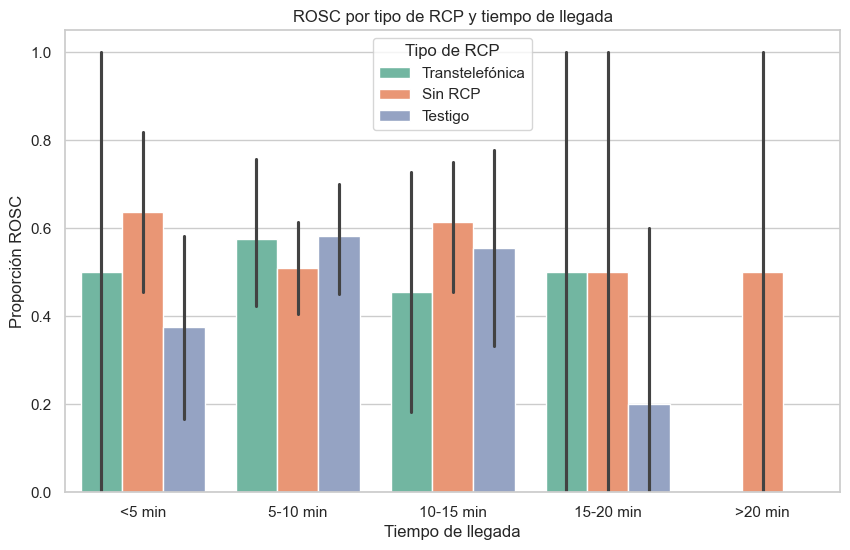

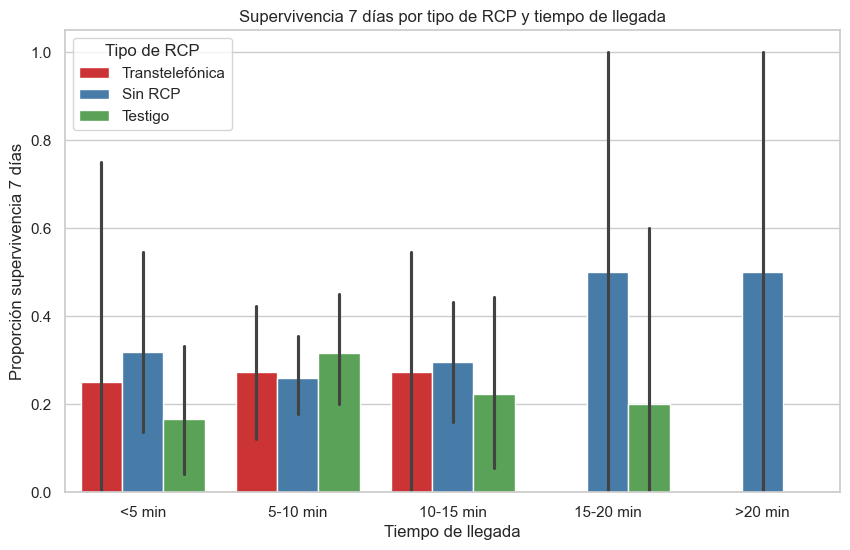

In [ ]:
# Gráficos de ROSC y supervivencia por tipo de RCP y rangos de tiempo de llegada
bins = [0, 300, 600, 900, 1200, df['TIEMPO_LLEGADA_UNIDAD'].max()]
labels = ['<5 min', '5-10 min', '10-15 min', '15-20 min', '>20 min']
df['TIEMPO_LLEGADA_GRUPO'] = pd.cut(df['TIEMPO_LLEGADA_UNIDAD'], bins=bins, labels=labels, right=False)

# ROSC por tipo de RCP y tiempo de llegada
plt.figure(figsize=(10,6))
sns.barplot(x='TIEMPO_LLEGADA_GRUPO', y='ROSC', hue='RCP_TIPO', data=df, palette='Set2')
plt.title('ROSC por tipo de RCP y tiempo de llegada')
plt.xlabel('Tiempo de llegada')
plt.ylabel('Proporción ROSC')
plt.legend(title='Tipo de RCP')
plt.savefig('../proyecto/figures/rosc_vs_tiempo_llegada_rcp_tel.png')
plt.show()

# Supervivencia por tipo de RCP y tiempo de llegada
plt.figure(figsize=(10,6))
sns.barplot(x='TIEMPO_LLEGADA_GRUPO', y='SOBREVIVE_7DIAS', hue='RCP_TIPO', data=df, palette='Set1')
plt.title('Supervivencia 7 días por tipo de RCP y tiempo de llegada')
plt.xlabel('Tiempo de llegada')
plt.ylabel('Proporción supervivencia 7 días')
plt.legend(title='Tipo de RCP')
plt.savefig('../proyecto/figures/supervivencia_rcp_tel_vs_tiempo_llegada.png')
plt.show()

--- OR para ROSC en tiempo de llegada <5 min ---
Intercept                         10.860576
C(RCP_TIPO)[T.Testigo]             0.340731
C(RCP_TIPO)[T.Transtelefónica]     0.599647
C(SEXO)[T.Masculino]               1.195206
EDAD                               0.970177
dtype: float64
                                       0           1
Intercept                       0.707840  166.636800
C(RCP_TIPO)[T.Testigo]          0.098762    1.175530
C(RCP_TIPO)[T.Transtelefónica]  0.067601    5.319079
C(SEXO)[T.Masculino]            0.331212    4.313002
EDAD                            0.935158    1.006508
--- OR para Supervivencia en tiempo de llegada <5 min ---
Intercept                         3.931109
C(RCP_TIPO)[T.Testigo]            0.409001
C(RCP_TIPO)[T.Transtelefónica]    0.770215
C(SEXO)[T.Masculino]              0.457323
EDAD                              0.974818
dtype: float64
                                       0          1
Intercept                       0.192735  80.180796
C(RCP_

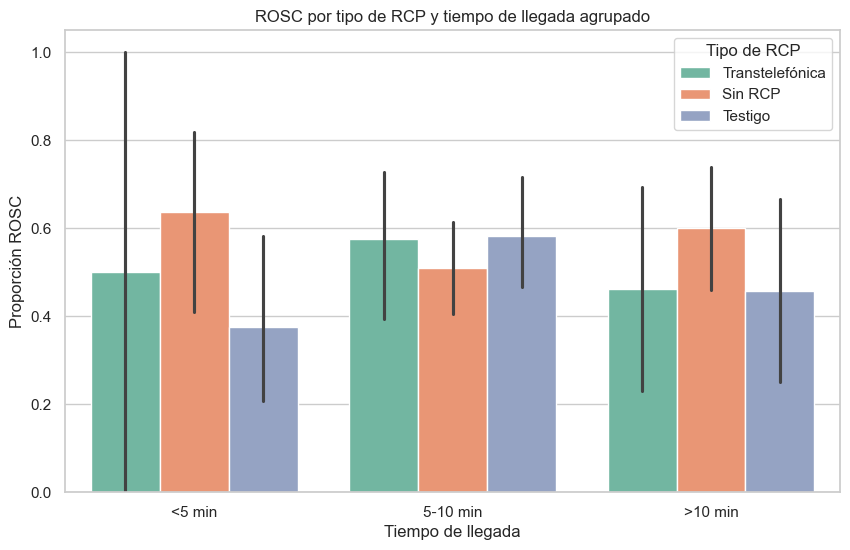

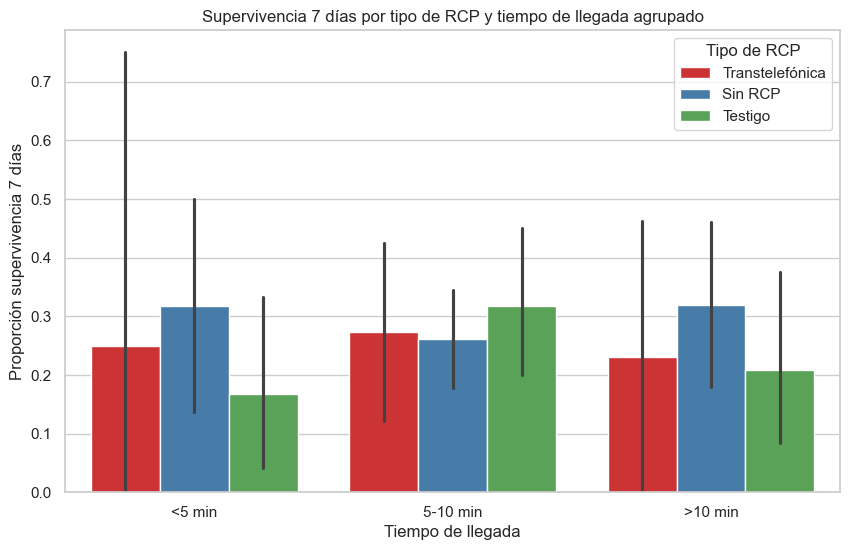

In [ ]:
# Agrupación de tiempos de llegada en <5 min, 5-10 min, >10 min
bins_sens = [0, 300, 600, df['TIEMPO_LLEGADA_UNIDAD'].max()]
labels_sens = ['<5 min', '5-10 min', '>10 min']
df['TIEMPO_LLEGADA_SENS'] = pd.cut(df['TIEMPO_LLEGADA_UNIDAD'], bins=bins_sens, labels=labels_sens, right=False)

# Análisis de sensibilidad: regresión logística por grupo de tiempo de llegada
import statsmodels.formula.api as smf
resultados = []
for grupo in labels_sens:
    sub = df[df['TIEMPO_LLEGADA_SENS']==grupo]
    if len(sub) > 0:
        model = smf.logit('ROSC_INT ~ C(RCP_TIPO) + C(SEXO) + EDAD', data=sub).fit(disp=0)
        or_vals = np.exp(model.params)
        conf_vals = np.exp(model.conf_int())
        resultados.append({'grupo': grupo, 'or': or_vals, 'conf': conf_vals})
        print(f'--- OR para ROSC en tiempo de llegada {grupo} ---')
        print(or_vals)
        print(conf_vals)

        model_surv = smf.logit('SOBREVIVE_7DIAS_INT ~ C(RCP_TIPO) + C(SEXO) + EDAD', data=sub).fit(disp=0)
        or_surv = np.exp(model_surv.params)
        conf_surv = np.exp(model_surv.conf_int())
        print(f'--- OR para Supervivencia en tiempo de llegada {grupo} ---')
        print(or_surv)
        print(conf_surv)

# Visualización de ROSC y supervivencia por tipo de RCP y tiempo de llegada agrupado
plt.figure(figsize=(10,6))
sns.barplot(x='TIEMPO_LLEGADA_SENS', y='ROSC', hue='RCP_TIPO', data=df, palette='Set2')
plt.title('ROSC por tipo de RCP y tiempo de llegada agrupado')
plt.xlabel('Tiempo de llegada')
plt.ylabel('Proporción ROSC')
plt.legend(title='Tipo de RCP')
plt.savefig('../proyecto/figures/rosc_grupotiempo_rcp_tel.png')
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x='TIEMPO_LLEGADA_SENS', y='SOBREVIVE_7DIAS', hue='RCP_TIPO', data=df, palette='Set1')
plt.title('Supervivencia 7 días por tipo de RCP y tiempo de llegada agrupado')
plt.xlabel('Tiempo de llegada')
plt.ylabel('Proporción supervivencia 7 días')
plt.legend(title='Tipo de RCP')
plt.savefig('../proyecto/figures/supervivencia_grupotiempo_rcp_tel.png')
plt.show()

--- OR para ROSC en tiempo de llegada Menor que la media ---
Intercept                         4.898664
C(RCP_TIPO)[T.Testigo]            0.776427
C(RCP_TIPO)[T.Transtelefónica]    1.144847
C(SEXO)[T.Masculino]              1.548773
EDAD                              0.972749
dtype: float64
                                       0          1
Intercept                       1.093888  21.937266
C(RCP_TIPO)[T.Testigo]          0.402978   1.495960
C(RCP_TIPO)[T.Transtelefónica]  0.477005   2.747717
C(SEXO)[T.Masculino]            0.722840   3.318434
EDAD                            0.954106   0.991756
--- OR para Supervivencia en tiempo de llegada Menor que la media ---
Intercept                         1.171519
C(RCP_TIPO)[T.Testigo]            0.784313
C(RCP_TIPO)[T.Transtelefónica]    0.934250
C(SEXO)[T.Masculino]              1.003678
EDAD                              0.982617
dtype: float64
                                       0         1
Intercept                       0.249906  5.49

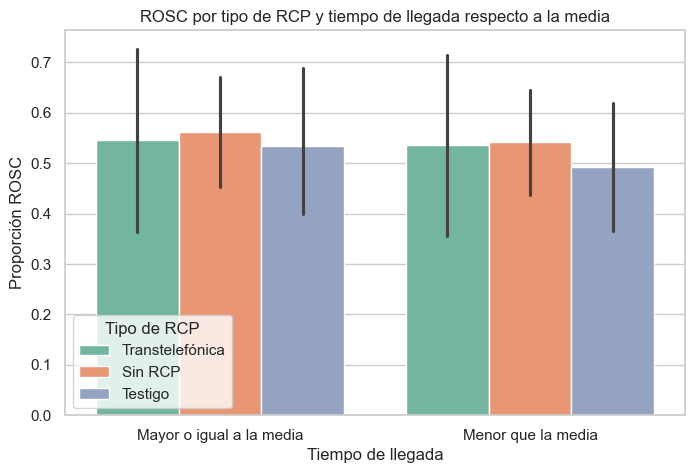

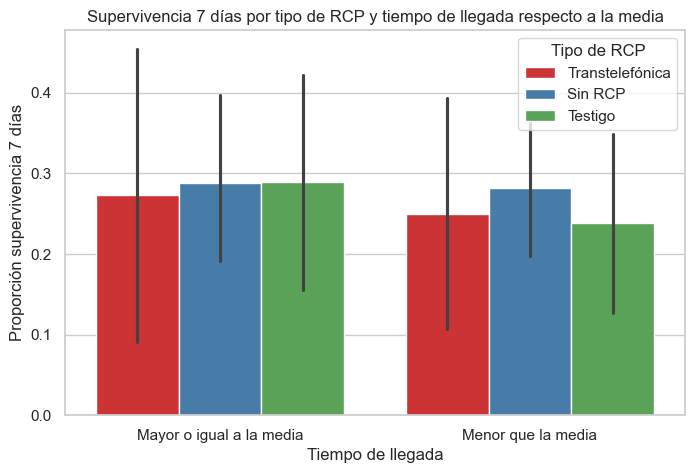

In [ ]:
# Agrupación de tiempos de llegada en menores y mayores que la media
media_tiempo = df['TIEMPO_LLEGADA_UNIDAD'].mean()
df['TIEMPO_LLEGADA_MEDIA'] = np.where(df['TIEMPO_LLEGADA_UNIDAD'] < media_tiempo, 'Menor que la media', 'Mayor o igual a la media')

# Análisis de sensibilidad: regresión logística por grupo de tiempo de llegada respecto a la media
for grupo in ['Menor que la media', 'Mayor o igual a la media']:
    sub = df[df['TIEMPO_LLEGADA_MEDIA']==grupo]
    if len(sub) > 0:
        model = smf.logit('ROSC_INT ~ C(RCP_TIPO) + C(SEXO) + EDAD', data=sub).fit(disp=0)
        or_vals = np.exp(model.params)
        conf_vals = np.exp(model.conf_int())
        print(f'--- OR para ROSC en tiempo de llegada {grupo} ---')
        print(or_vals)
        print(conf_vals)

        model_surv = smf.logit('SOBREVIVE_7DIAS_INT ~ C(RCP_TIPO) + C(SEXO) + EDAD', data=sub).fit(disp=0)
        or_surv = np.exp(model_surv.params)
        conf_surv = np.exp(model_surv.conf_int())
        print(f'--- OR para Supervivencia en tiempo de llegada {grupo} ---')
        print(or_surv)
        print(conf_surv)

# Visualización de ROSC y supervivencia por tipo de RCP y tiempo de llegada respecto a la media
plt.figure(figsize=(8,5))
sns.barplot(x='TIEMPO_LLEGADA_MEDIA', y='ROSC', hue='RCP_TIPO', data=df, palette='Set2')
plt.title('ROSC por tipo de RCP y tiempo de llegada respecto a la media')
plt.xlabel('Tiempo de llegada')
plt.ylabel('Proporción ROSC')
plt.legend(title='Tipo de RCP')
plt.savefig('../proyecto/figures/rosc_vs_tiempo_llegada_media_rcp_tel.png')
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x='TIEMPO_LLEGADA_MEDIA', y='SOBREVIVE_7DIAS', hue='RCP_TIPO', data=df, palette='Set1')
plt.title('Supervivencia 7 días por tipo de RCP y tiempo de llegada respecto a la media')
plt.xlabel('Tiempo de llegada')
plt.ylabel('Proporción supervivencia 7 días')
plt.legend(title='Tipo de RCP')
plt.savefig('../proyecto/figures/supervivencia_vs_tiempo_llegada_media_rcp_tel.png')
plt.show()

In [38]:
# Tabla resumen de Odds Ratios (OR) e intervalos de confianza para ROSC y supervivencia por tipo de RCP y tiempo de llegada respecto a la media
import pandas as pd

or_results = []
for grupo in ['Menor que la media', 'Mayor o igual a la media']:
    sub = df[df['TIEMPO_LLEGADA_MEDIA']==grupo]
    if len(sub) > 0:
        model_rosc = smf.logit('ROSC_INT ~ C(RCP_TIPO) + C(SEXO) + EDAD', data=sub).fit(disp=0)
        or_vals_rosc = np.exp(model_rosc.params)
        conf_vals_rosc = np.exp(model_rosc.conf_int())
        for idx in or_vals_rosc.index:
            or_results.append({
                'Outcome': 'ROSC',
                'Tiempo_llegada': grupo,
                'Variable': idx,
                'OR': or_vals_rosc[idx],
                'CI_low': conf_vals_rosc.loc[idx, 0],
                'CI_high': conf_vals_rosc.loc[idx, 1]
            })
        model_surv = smf.logit('SOBREVIVE_7DIAS_INT ~ C(RCP_TIPO) + C(SEXO) + EDAD', data=sub).fit(disp=0)
        or_vals_surv = np.exp(model_surv.params)
        conf_vals_surv = np.exp(model_surv.conf_int())
        for idx in or_vals_surv.index:
            or_results.append({
                'Outcome': 'Supervivencia',
                'Tiempo_llegada': grupo,
                'Variable': idx,
                'OR': or_vals_surv[idx],
                'CI_low': conf_vals_surv.loc[idx, 0],
                'CI_high': conf_vals_surv.loc[idx, 1]
            })

or_df = pd.DataFrame(or_results)
display(or_df)

KeyError: 'TIEMPO_LLEGADA_MEDIA'

,Outcome,RCP_TIPO,Variable,pvalue
0,ROSC,Sin RCP,EDAD,0.641998
1,ROSC,Sin RCP,TIEMPO_LLEGADA_UNIDAD,0.223607
2,ROSC,Testigo,EDAD,0.006566
3,ROSC,Testigo,TIEMPO_LLEGADA_UNIDAD,0.635226
4,ROSC,Transtelefónica,EDAD,0.000041
5,ROSC,Transtelefónica,TIEMPO_LLEGADA_UNIDAD,0.475282
6,SOBREVIVE_7DIAS,Sin RCP,EDAD,0.080108
7,SOBREVIVE_7DIAS,Sin RCP,TIEMPO_LLEGADA_UNIDAD,0.743307
8,SOBREVIVE_7DIAS,Testigo,EDAD,0.208543
9,SOBREVIVE_7DIAS,Testigo,TIEMPO_LLEGADA_UNIDAD,0.973407


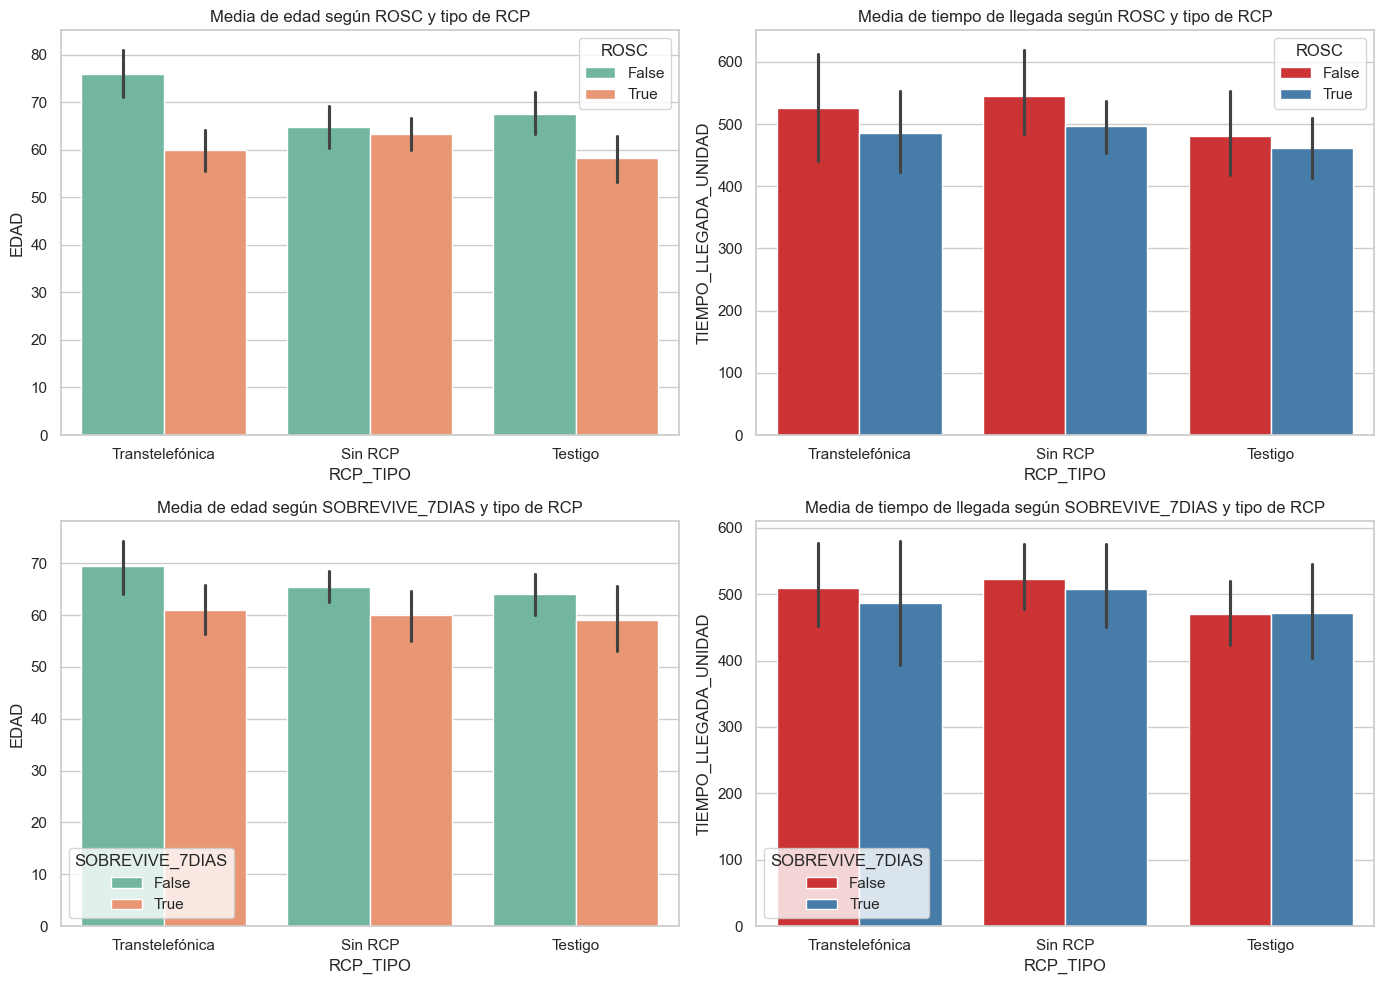

In [39]:
# Comparativa de medias (t-test) y gráfica para ROSC y supervivencia según tipo de RCP
from scipy.stats import ttest_ind

# Preparar datos
grupos = ['Sin RCP', 'Testigo', 'Transtelefónica']
resultados_ttest = []
for outcome in ['ROSC', 'SOBREVIVE_7DIAS']:
    for rcp in grupos:
        sub = df[df['RCP_TIPO']==rcp]
        vals_true = sub[sub[outcome]==1]['EDAD']
        vals_false = sub[sub[outcome]==0]['EDAD']
        ttest = ttest_ind(vals_true, vals_false, nan_policy='omit')
        resultados_ttest.append({'Outcome': outcome, 'RCP_TIPO': rcp, 'Variable': 'EDAD', 'pvalue': ttest.pvalue})
        vals_true = sub[sub[outcome]==1]['TIEMPO_LLEGADA_UNIDAD']
        vals_false = sub[sub[outcome]==0]['TIEMPO_LLEGADA_UNIDAD']
        ttest = ttest_ind(vals_true, vals_false, nan_policy='omit')
        resultados_ttest.append({'Outcome': outcome, 'RCP_TIPO': rcp, 'Variable': 'TIEMPO_LLEGADA_UNIDAD', 'pvalue': ttest.pvalue})

ttest_df = pd.DataFrame(resultados_ttest)
display(ttest_df)

# Gráfica comparativa de medias de edad y tiempo de llegada según ROSC y supervivencia para cada tipo de RCP
fig, axes = plt.subplots(2, 2, figsize=(14,10))
for i, outcome in enumerate(['ROSC', 'SOBREVIVE_7DIAS']):
    sns.barplot(x='RCP_TIPO', y='EDAD', hue=outcome, data=df, ax=axes[i,0], palette='Set2')
    axes[i,0].set_title(f'Media de edad según {outcome} y tipo de RCP')
    sns.barplot(x='RCP_TIPO', y='TIEMPO_LLEGADA_UNIDAD', hue=outcome, data=df, ax=axes[i,1], palette='Set1')
    axes[i,1].set_title(f'Media de tiempo de llegada según {outcome} y tipo de RCP')
plt.tight_layout()
plt.savefig('../proyecto/figures/boxplots_edad_tiempo_rcptel.png')
plt.show()